# Write-up and README

## Link Equations

For the t-links, used the following equation to determine the foreground weighting:

$$ \text{weight} = \frac{1}{N} \sum_{fgpixel}^{N} \exp{\frac{-dist(pixel,fgpixel)}{\sigma}}$$

I used a similar weighting for background.

For neighbors, I simply used:

$$ \text{weight} = \exp{\frac{-dist(pixel,neighbor)}{\sigma}}$$

I also used a simple squared distance function.

$$ \text{dist(rgb1, rgb2)} = (r_1-r_2)^2 + (g_1-g_2)^2 + (b_1-b_2)^2 $$

## Analysis

Overall, my graph cut algorithm worked well on all the images I tried. It seemed that a smaller $\sigma$ worked the best for this algorithm. Larger sigmas start to blur the selection it seemed.

The best image I was able to do was the puffer fish image. It took the longest because the number of known points was large, but the final result worked really well. This can be seen in final_fish.png.

## Running the code

Go through the notebook and define all of the functions. From there, you can simply call the graphCut function as shown at the very bottom of the notebook.

In [10]:
import maxflow
import numpy as np
import scipy
from scipy.misc import imread
from scipy.misc import imsave
from matplotlib import pyplot as plt
from matplotlib import colors
import maxflow
import json

In [11]:
def plotImage(image,title=""):
    plt.imshow(image, cmap='gray', interpolation = 'none')
    plt.title(title)
    plt.show()
    
# Make a color distance function
def dist(rgb1, rgb2):
    return (rgb1[0]-rgb2[0])**2 + (rgb1[1]-rgb2[1])**2 + (rgb1[2]-rgb2[2])**2
    
def get_twitter():
    image = plt.imread("bird1.png")
    known_fore = [
        (150, 300), (151, 300), (152, 300),
        (150, 301), (151, 301), (152, 301),
        (150, 302), (151, 302), (152, 302)      
    ]
    known_back = [
        (0, 0), (0, 1), (0, 2), (0, 3), (0, 4),
        (1, 0), (1, 1), (1, 2), (1, 3), (1, 4),
        (2, 0), (2, 1), (2, 2), (2, 3), (2, 4),
    ]
    return image, known_fore, known_back

def get_android():
    image = plt.imread("android.png")
    known_fore = [
        (105, 114), (42, 94), (107, 48), (158, 79), (112, 170), (114, 92)
    ]
    known_back = [
        (0, 0), (49, 174), (153, 67), (175, 187), (107, 18)
    ]
    return image, known_fore, known_back

def get_fish():
    image = plt.imread("pufferfish.png")
    
    known_fore = [
        [193, 65], [193, 66], [193, 67], [193, 68], [193, 69], [193, 70], [193, 71], [192, 72], [192, 73], [192, 74], [191, 75], [191, 76], [345, 113], [345, 114], [345, 116], [345, 117], [345, 118], [345, 119], [345, 120], [345, 121], [345, 122], [345, 123], [345, 125], [345, 126], [345, 127], [345, 128], [345, 129], [345, 130], [345, 131], [345, 132], [345, 134], [345, 135], [345, 137], [345, 139], [345, 141], [345, 142], [345, 143], [345, 144], [345, 146], [345, 148], [345, 149], [345, 151] 
    ]
    known_back = [
        [73, 53], [68, 55], [67, 56], [64, 57], [63, 59], [61, 61], [60, 61], [59, 63], [56, 67], [56, 70], [55, 72], [53, 78], [51, 81], [390, 13], [393, 15], [396, 16], [397, 16], [399, 18], [402, 18], [404, 20], [405, 20], [410, 22], [414, 22], [415, 23], [417, 23], [419, 24], [420, 24], [421, 24], [423, 24], [424, 24], [426, 26], [427, 26], [429, 26], [430, 26], [431, 27], [432, 27], [433, 27], [435, 27], [436, 27], [439, 27], [440, 28], [441, 29], [442, 30], [443, 31], [444, 32], [446, 34], [447, 35]
    ]
    
    #Switch to rows cols format
    known_fore = [(y,x) for (x,y) in known_fore ]
    known_back = [(y,x) for (x,y) in known_back ]

    return image, known_fore, known_back
    


In [12]:
def getTEdges(img, foreground, background, sigma = .1):

    (rows, cols, ch) = img.shape

    # Determine Source and Terminal Edges
    bg_results = np.zeros((rows,cols))
    fg_results = np.zeros((rows,cols))

    norm_bg = len(background)
    norm_fg = len(background)

    for i in range(0,rows):
        for j in range(0,cols):

            total = 0

            # Background comparison
            for bg_loc in background:

                rgb_pix = img[i][j]
                rgb_bg = img[bg_loc[0],bg_loc[1]]

                #Gaussian Weighting Function
                total += np.exp(  -dist(rgb_pix,rgb_bg)/(sigma)   )

            bg_results[i][j] = total/norm_bg

            # Foreground comparison
            total = 0

            for fg_loc in foreground:

                rgb_pix = img[i][j]
                rgb_fg = img[fg_loc[0],fg_loc[1]]

                #Gaussian Weighting Function
                total += np.exp(  -dist(rgb_pix,rgb_fg)/(sigma)   )

            fg_results[i][j] = total/norm_fg
            
    return fg_results, bg_results


In [13]:
def getGraph(img, fg_results, bg_results, sigma = .1):

    (rows, cols, ch) = img.shape
    
    # Generate Max Flow Graph
    g = maxflow.Graph[float]()
    nodeids = g.add_grid_nodes((rows,cols))

    # Add Source and Terminal Weights
    g.add_grid_tedges(nodeids, fg_results, bg_results)

    # Get Neighbor Weights
    for i in range(0, rows-1):
        for j in range(0, cols-1):

            val_right = np.exp(-dist(img[i][j],img[i][j+1])/(sigma))
            val_down  = np.exp(-dist(img[i][j],img[i+1][j])/(sigma))

            g.add_edge(nodeids[i][j], nodeids[i][j+1], val_right, val_right)
            g.add_edge(nodeids[i][j], nodeids[i+1][j], val_down, val_down)

    # Right and Bottom Edge
    for i in range(0, rows-1):
        val_down = np.exp(-dist(img[i][cols-1],img[i+1][cols-1])/(2*sigma))
        g.add_edge(nodeids[i][j], nodeids[i+1][j], val_down, val_down)

    for j in range(0, cols-1):
        val_right = np.exp(-dist(img[rows-1][j],img[rows-1][j+1])/(2*sigma))
        g.add_edge(nodeids[rows-1][j], nodeids[rows-1][j+1], val_right, val_right)
        
    return g, nodeids

In [14]:
def cutAndPlot(g, nodeids,img, greyscale=False):
    # Grab Foreground and Background
    g.maxflow()

    sgm = g.get_grid_segments(nodeids)

    answer = np.int_(np.logical_not(sgm))

    plotImage(answer, "Thresholded Selection")
    
    # Plot Original Image with Grey Scale selection
    # Only needed for pufferfish example

    if greyscale:
    
        (rows, cols, ch) = img.shape
    
        hsb = colors.rgb_to_hsv(img)

        for i in range(0,rows):
            for j in range(0,cols):

                #Grey out background
                hsb[i,j,1] = hsb[i,j,1] * answer[i][j]

        final = colors.hsv_to_rgb(hsb)

        plotImage(final,"Image with Selection")

In [15]:
def graphCut(img, foreground, background, grayscale = True ,sigma = .1):
    
    fg, bg = getTEdges(img, foreground, background, sigma)
    g, nodeids = getGraph(img, fg, bg, sigma)
    cutAndPlot(g, nodeids, img, greyscale)


# Full Implementation

I have provided 3 example images to load: **get_bird, get_android,** and **get_fish**.

**Note:** get_fish takes about a minute or two to run.

**Running Your Own Image:

If you would like to run your own image, simply commment my line of code and uncomment the other lines of code. This will allow you to load from a json file.

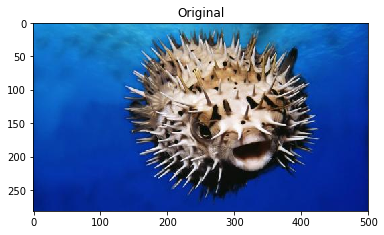

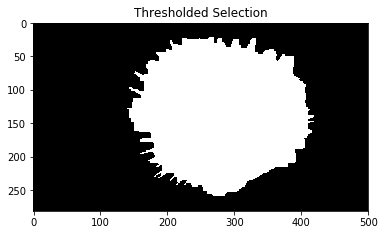

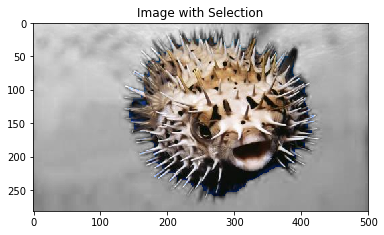

In [16]:
# For your own image and data

#img = imread("filename.png")
#with open("file.json") as data_file:
#    data = json.load(data_file)
#background = data[u'bg']
#foreground = data[u'fg']
# Switch to rows cols format
#foreground = [(y,x) for (x,y) in foreground ]
#background = [(y,x) for (x,y) in background ]

img, foreground, background = get_fish()

plotImage(img, "Original")

#Turn this on if you want to greyscale the background of an image
greyscale = True

graphCut(img, foreground, background, greyscale)